# SustainCluster Agent Evaluation Notebook

This notebook is designed to evaluate the performance of different scheduling strategies
within the SustainCluster environment. You can evaluate:
1. Trained Reinforcement Learning (RL) agents (e.g., SAC).
2. Rule-Based Controllers (RBCs).

The evaluation involves running a simulation for a specified period (e.g., 7/30 days)
and collecting various performance metrics. These metrics are then aggregated and
visualized to compare different controllers.

## 1. Setup and Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter
import seaborn as sns
import datetime
import logging
import os
import sys
import yaml # For loading YAML, might be needed by utils.config_loader

**Adjust Python Path to Project Root**

Since this notebook is in the `notebooks/` subdirectory, we need to add the project's root directory to the Python path so that modules like `envs`, `simulation`, `utils`, etc., can be imported correctly.

In [2]:
# Add project root to sys.path
notebook_dir = os.getcwd()
project_root = notebook_dir # Assumes notebook is in 'notebooks/' one level down from root
if project_root not in sys.path:
    sys.path.insert(0, project_root) # Insert at beginning to prioritize project modules
    print(f"Project root '{project_root}' added to sys.path.")
else:
    print(f"Project root '{project_root}' already in sys.path.")

Project root '/lustre/guillant/new_green-dcc' added to sys.path.


In [3]:
# Import project-specific modules

try:
    from rl_components.agent_net import ActorNet
    from envs.task_scheduling_env import TaskSchedulingEnv
    from simulation.cluster_manager import DatacenterClusterManager
    from utils.config_loader import load_yaml # Assuming this function handles YAML loading
    from rewards.predefined.composite_reward import CompositeReward
except ImportError as e:
    print(f"ImportError: {e}. Please ensure the project root was correctly added to sys.path.")
    print(f"Current sys.path: {sys.path}")
    raise

## 2. Configuration and Logger Setup

In [8]:
# --- Configuration Parameters ---

# Timestamp for unique log/output file names
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Logger Setup ---
# Create logs and outputs directory in the project root if they don't exist
logs_dir_in_root = os.path.join(project_root, "logs")
outputs_dir_in_root = os.path.join(project_root, "outputs")
if not os.path.exists(logs_dir_in_root):
    os.makedirs(logs_dir_in_root)
if not os.path.exists(outputs_dir_in_root):
    os.makedirs(outputs_dir_in_root)

log_path = os.path.join(logs_dir_in_root, f"evaluation_{timestamp}.log")


logger = logging.getLogger(f"eval_logger_{timestamp}") # Unique logger name
if not logger.handlers: # Avoid adding handlers multiple times if re-running cells
    logger.setLevel(logging.INFO)

    # File handler (full log)
    file_handler = logging.FileHandler(log_path, mode="w", encoding="utf-8")
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(logging.Formatter(
        "%(asctime)s - %(levelname)s - %(module)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    ))
    logger.addHandler(file_handler)

    # Console handler (for Jupyter, show INFO+; for scripts, might be WARNING+)
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.WARNING)
    console_handler.setFormatter(logging.Formatter(
        "[%(levelname)s] %(message)s"
    ))
    logger.addHandler(console_handler)

logger.info(f"Evaluation run started at {timestamp}")
logger.info(f"Full logs will be saved to: {log_path}")

# Set Seaborn style
sns.set_theme(style="whitegrid")

## 3. Environment Creation Function

In [9]:
def make_eval_env(sim_config_rel_path="configs/env/sim_config.yaml",
                  dc_config_rel_path="configs/env/datacenters.yaml",
                  reward_config_rel_path="configs/env/reward_config.yaml",
                  eval_mode=True,
                  strategy_override=None):
    """
    Creates and returns the SustainCluster evaluation environment.
    Paths are relative to the project root.
    """
    # Construct absolute paths for main config files
    sim_config_path = os.path.join(project_root, sim_config_rel_path)
    dc_config_path = os.path.join(project_root, dc_config_rel_path)
    reward_config_path = os.path.join(project_root, reward_config_rel_path)

    sim_cfg_dict = load_yaml(sim_config_path)
    if sim_cfg_dict is None or "simulation" not in sim_cfg_dict:
        logger.error(f"Failed to load or parse sim_config from {sim_config_path}")
        raise ValueError("Simulation configuration error.")
    sim_cfg = sim_cfg_dict["simulation"]

    dc_cfg_list_dict = load_yaml(dc_config_path) # Renamed to avoid conflict
    if dc_cfg_list_dict is None or "datacenters" not in dc_cfg_list_dict:
        logger.error(f"Failed to load or parse dc_config from {dc_config_path}")
        raise ValueError("Datacenter configuration error.")
    dc_config_list_from_yaml = dc_cfg_list_dict["datacenters"] # This is a list of DC configs

    # --- Modification Starts Here ---
    # Resolve dc_config_file paths to be absolute from project_root
    processed_dc_config_list = []
    for dc_conf_item in dc_config_list_from_yaml:
        if "dc_config_file" in dc_conf_item:
            relative_physics_path = dc_conf_item["dc_config_file"]
            absolute_physics_path = os.path.join(project_root, relative_physics_path)
            if not os.path.exists(absolute_physics_path):
                logger.error(f"DC Physics config file not found: {absolute_physics_path} (resolved from relative: {relative_physics_path})")
                raise FileNotFoundError(f"DC Physics config file not found: {absolute_physics_path}")
            dc_conf_item["dc_config_file"] = absolute_physics_path # Update with absolute path
        processed_dc_config_list.append(dc_conf_item)
    # --- Modification Ends Here ---


    reward_cfg_dict = load_yaml(reward_config_path)
    if reward_cfg_dict is None or "reward" not in reward_cfg_dict:
        logger.error(f"Failed to load or parse reward_config from {reward_config_path}")
        raise ValueError("Reward configuration error.")
    reward_cfg = reward_cfg_dict["reward"]

    workload_rel_path = sim_cfg["workload_path"]
    workload_abs_path = os.path.join(project_root, workload_rel_path)
    # ... (rest of workload path checking logic from previous version) ...
    if not os.path.exists(workload_abs_path):
        zip_path = workload_abs_path.replace(".pkl", ".zip")
        if not os.path.exists(zip_path):
            logger.error(f"Workload .pkl or .zip not found: {workload_abs_path} or {zip_path}")
            raise FileNotFoundError(f"Workload .pkl or .zip not found: {workload_abs_path} or {zip_path}")


    start_time = pd.Timestamp(datetime.datetime(sim_cfg["year"], sim_cfg["month"], sim_cfg["init_day"],
                                                sim_cfg["init_hour"], 0, tzinfo=datetime.timezone.utc))
    end_time = start_time + datetime.timedelta(days=sim_cfg["duration_days"])

    current_strategy = strategy_override if strategy_override else sim_cfg["strategy"]
    logger.info(f"Initializing DatacenterClusterManager with strategy: {current_strategy}")

    cluster = DatacenterClusterManager(
        config_list=processed_dc_config_list, # Use the processed list with absolute paths
        simulation_year=sim_cfg["year"],
        init_day=int(sim_cfg.get("init_day_abs", sim_cfg["month"] * 30.5)),
        init_hour=sim_cfg["init_hour"],
        strategy=current_strategy,
        tasks_file_path=workload_abs_path,
        shuffle_datacenter_order= not eval_mode,
        cloud_provider=sim_cfg["cloud_provider"],
        logger=logger
    )

    reward_fn = CompositeReward(
        components=reward_cfg["components"],
        normalize=reward_cfg.get("normalize", False)
    )

    env = TaskSchedulingEnv(
        cluster_manager=cluster,
        start_time=start_time,
        end_time=end_time,
        reward_fn=reward_fn,
        writer=None
    )
    return env

## 4. Evaluation Parameters

Set the parameters for this evaluation run.
- `EVALUATION_STRATEGY`:
  - Set to `"manual_rl"` to evaluate a trained RL agent.
  - Set to an RBC name (e.g., `"lowest_carbon"`, `"local_only"`) to evaluate that RBC.
- `CHECKPOINT_PATH`: Path to the trained RL agent checkpoint (only used if `EVALUATION_STRATEGY` is `"manual_rl"`).
- `EVALUATION_DAYS`: Number of days to simulate for the evaluation.
- `EVALUATION_SEED`: Random seed for reproducibility.

In [10]:
# --- Evaluation Run Configuration ---
EVALUATION_STRATEGY = "manual_rl"  # Options: "manual_rl", "local_only", "lowest_carbon", "lowest_price", etc.
# EVALUATION_STRATEGY = "local_only"

# Only used if EVALUATION_STRATEGY is "manual_rl"
CHECKPOINT_REL_PATH = "colab_checkpoints/checkpoint_SAC_step_2520000.pth"

EVALUATION_DAYS = 7 # Number of days for the evaluation period
EVALUATION_SEED = 123 # Seed for environment reset

# Determine if we are using an RL actor or an RBC
use_rl_actor = (EVALUATION_STRATEGY == "manual_rl")
CHECKPOINT_PATH = os.path.join(project_root, CHECKPOINT_REL_PATH) if use_rl_actor else None

logger.info(f"--- Starting Evaluation for Strategy: {EVALUATION_STRATEGY} ---")
if use_rl_actor:
    logger.info(f"RL Agent Checkpoint (absolute path): {CHECKPOINT_PATH}")
logger.info(f"Evaluation Duration: {EVALUATION_DAYS} days")
logger.info(f"Evaluation Seed: {EVALUATION_SEED}")

## 5. Initialize Environment and Agent

In [11]:
# Create the evaluation environment
env = make_eval_env(eval_mode=True, strategy_override=EVALUATION_STRATEGY)

temp_obs_list, _ = env.reset(seed=EVALUATION_SEED) # obs is a list of np.arrays
obs_dim = 0
if temp_obs_list: # If list is not empty
    obs_dim = np.shape(temp_obs_list[0])[0]
else: # Handle case where initial reset might yield no tasks
    logger.warning("Initial reset yielded no tasks. Stepping once to try to get observation dimension.")
    temp_obs_list_after_step, _, _, _, _ = env.step([])
    if temp_obs_list_after_step:
        obs_dim = temp_obs_list_after_step[0].shape[0]
    else:
        logger.error("Could not obtain a valid initial observation to determine obs_dim even after an empty step.")
        # Fallback: try to get from env.observation_space if it's a Box of the per-task obs
        if isinstance(env.observation_space, spaces.Box):
             obs_dim = env.observation_space.shape[0]
             logger.info(f"Using obs_dim from env.observation_space: {obs_dim}")
        else:
             raise ValueError("Environment observation error: obs_dim could not be determined.")

act_dim = env.num_dcs + 1
logger.info(f"Observation dimension (per task): {obs_dim}")
logger.info(f"Action dimension (per task): {act_dim}")

actor = None
if use_rl_actor:
    if CHECKPOINT_PATH is None or not os.path.exists(CHECKPOINT_PATH):
        logger.error(f"RL Agent Checkpoint not found or path is None: {CHECKPOINT_PATH}")
        raise FileNotFoundError(f"Checkpoint not found: {CHECKPOINT_PATH}")
    
    logger.info(f"Loading trained actor model from: {CHECKPOINT_PATH}")
    # TODO: The hidden_dim should ideally be loaded from checkpoint or config
    # For now, ensure it matches the trained model's architecture.
    actor_hidden_dim = 64 # Default, adjust if your saved model used a different size
    try:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device("cpu"))
        # Try to get hidden_dim from checkpoint if saved, otherwise use default
        if 'model_config' in checkpoint and 'hidden_dim' in checkpoint['model_config']:
            actor_hidden_dim = checkpoint['model_config']['hidden_dim']
            logger.info(f"Actor hidden_dim loaded from checkpoint: {actor_hidden_dim}")
        else:
            logger.warning(f"actor_hidden_dim not found in checkpoint, using default: {actor_hidden_dim}")

        actor = ActorNet(obs_dim, act_dim, hidden_dim=actor_hidden_dim)
        actor.load_state_dict(checkpoint["actor_state_dict"])
        actor.eval()
        logger.info("Actor model loaded successfully.")
    except Exception as e:
        logger.error(f"Error loading actor model state_dict: {e}")
        raise
else:
    logger.info(f"Using Rule-Based Controller: {EVALUATION_STRATEGY}")

[WARNING] actor_hidden_dim not found in checkpoint, using default: 64


## 6. Run Simulation Loop

In [12]:
# Reset environment for the actual evaluation run
obs, _ = env.reset(seed=EVALUATION_SEED)

# Data collection lists
all_metrics_per_dc_per_step = [] # List of dicts (one per step, keys are DC names, values are info dicts)
global_transmission_costs_per_step = [] # List of floats
rewards_per_step = []
delayed_tasks_per_step = []

# Simulation steps
# Each step is 15 minutes. 4 steps per hour, 24 hours per day.
num_simulation_steps = EVALUATION_DAYS * 24 * 4
logger.info(f"Total simulation steps for evaluation: {num_simulation_steps}")

for step in tqdm(range(num_simulation_steps), desc="Simulating"):
    actions_for_current_step = []
    if not obs: # No tasks are pending
        actions_for_current_step = []
        delayed_tasks_per_step.append(0)
    elif use_rl_actor and actor:
        obs_tensor = torch.FloatTensor(obs) # obs is a list of np.arrays
        with torch.no_grad():
            logits = actor(obs_tensor)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            actions_for_current_step = dist.sample().cpu().numpy().tolist()
        
        current_delayed_count = sum(1 for a in actions_for_current_step if a == 0)
        delayed_tasks_per_step.append(current_delayed_count)
    else: # RBC mode or actor not loaded
        actions_for_current_step = [] # For RBCs, env handles assignment internally
        delayed_tasks_per_step.append(0)


    obs, reward, done, truncated, info = env.step(actions_for_current_step)
    
    all_metrics_per_dc_per_step.append(info["datacenter_infos"])
    global_transmission_costs_per_step.append(info["transmission_cost_total_usd"])
    rewards_per_step.append(reward)

    if done or truncated:
        logger.info(f"Episode finished at step {step+1}/{num_simulation_steps}. Resetting for continuation if needed (but eval usually one long run).")
        # For a fixed evaluation period, we typically don't reset within the loop unless
        # the environment terminates unexpectedly or the goal is multi-episode eval.
        # If 'duration_days' in sim_config is less than EVALUATION_DAYS, it will terminate.
        # For now, assume one continuous run up to num_simulation_steps.
        break # Exit loop if environment signals done/truncated prematurely for the eval period

logger.info("Simulation loop completed.")

Simulating:   0%|          | 0/672 [00:00<?, ?it/s]

## 7. Process and Aggregate Results

In [13]:
# Flatten the collected data into a Pandas DataFrame for easier analysis
flat_records = []
for t, timestep_dc_infos in enumerate(all_metrics_per_dc_per_step):
    for dc_name, dc_info_at_step in timestep_dc_infos.items():
        # Ensure all expected keys exist, providing defaults if necessary
        common_info = dc_info_at_step.get("__common__", {})
        agent_dc_info = dc_info_at_step.get("agent_dc", {}) # Info from dc_gym
        sla_info = common_info.get("__sla__", {"met": 0, "violated": 0})

        record = {
            "timestep": t,
            "datacenter": dc_name,
            "energy_cost_usd": common_info.get("energy_cost_USD", np.nan),
            "energy_kwh": common_info.get("energy_consumption_kwh", np.nan),
            "carbon_kg": common_info.get("carbon_emissions_kg", np.nan),
            "price_per_kwh": common_info.get("price_USD_kwh", np.nan),
            "carbon_intensity_gco2_kwh": common_info.get("ci", np.nan), # Assuming 'ci' is in gCO2/kWh
            "temperature_c": common_info.get("weather", np.nan), # Assuming 'weather' is temp
            "cpu_util_pct": common_info.get("cpu_util_percent", np.nan),
            "gpu_util_pct": common_info.get("gpu_util_percent", np.nan),
            "mem_util_pct": common_info.get("mem_util_percent", np.nan),
            "running_tasks_count": common_info.get("running_tasks", 0),
            "pending_tasks_count": common_info.get("pending_tasks", 0),
            "tasks_assigned_count": common_info.get("tasks_assigned", 0),
            "sla_met_count": sla_info.get("met", 0),
            "sla_violated_count": sla_info.get("violated", 0),
            "hvac_setpoint_c": agent_dc_info.get("dc_crac_setpoint", np.nan), # From dc_gym's info dict
            "water_usage_m3": agent_dc_info.get("dc_water_usage", np.nan) # Assuming this is in m3
        }
        flat_records.append(record)

results_df = pd.DataFrame(flat_records)
logger.info(f"Created results DataFrame with {len(results_df)} records.")
if not results_df.empty:
    print("Sample of processed results_df:")
    print(results_df.head())
else:
    logger.warning("results_df is empty. No data processed.")

Sample of processed results_df:
   timestep datacenter  energy_cost_usd  energy_kwh   carbon_kg  \
0         0        DC1        13.741063  193.533452   49.196684   
1         0        DC2        36.467500  306.652138  130.433145   
2         0        DC3        30.565100  397.384932   70.870312   
3         0        DC4        23.660262  264.474503   98.690279   
4         0        DC5        -9.309230  237.939012  151.412947   

   price_per_kwh  carbon_intensity_gco2_kwh  temperature_c  cpu_util_pct  \
0      71.000973                 253.667469      18.135292           0.0   
1     118.921394                 427.595688      23.761776           0.0   
2      76.915598                 176.636670      13.627090           0.0   
3      89.461410                 373.196121      27.148865           0.0   
4     -39.124439                 637.486950      10.457051           0.0   

   gpu_util_pct  mem_util_pct  running_tasks_count  pending_tasks_count  \
0           0.0           0.0    

In [14]:
# Aggregate metrics per datacenter
if not results_df.empty:
    summary_df = results_df.groupby("datacenter").agg(
        total_energy_cost_usd=("energy_cost_usd", "sum"),
        total_energy_mwh=("energy_kwh", lambda x: x.sum() / 1000), # Convert kWh to MWh
        total_carbon_tonnes=("carbon_kg", lambda x: x.sum() / 1000), # Convert kg to tonnes
        total_water_m3=("water_usage_m3", "sum"),
        avg_price_usd_kwh=("price_per_kwh", "mean"),
        avg_carbon_intensity_gco2_kwh=("carbon_intensity_gco2_kwh", "mean"),
        avg_temperature_c=("temperature_c", "mean"),
        avg_cpu_util_pct=("cpu_util_pct", "mean"),
        avg_gpu_util_pct=("gpu_util_pct", "mean"),
        avg_mem_util_pct=("mem_util_pct", "mean"),
        total_tasks_finished=("sla_met_count", "sum"), # Assuming sla_met means finished within SLA
        total_sla_violated=("sla_violated_count", "sum"),
        avg_hvac_setpoint_c=("hvac_setpoint_c", "mean")
    ).reset_index()

    # Calculate SLA Violation Rate
    summary_df["total_tasks_processed"] = summary_df["total_tasks_finished"] + summary_df["total_sla_violated"]
    summary_df["sla_violation_rate_pct"] = (
        summary_df["total_sla_violated"] / summary_df["total_tasks_processed"].replace(0, np.nan)
    ) * 100
    summary_df.fillna({'sla_violation_rate_pct': 0}, inplace=True) # If no tasks, rate is 0

    # Calculate global aggregates
    global_summary = {
        "Datacenter": "Global Total/Avg",
        "total_energy_cost_usd": summary_df["total_energy_cost_usd"].sum(),
        "total_energy_mwh": summary_df["total_energy_mwh"].sum(),
        "total_carbon_tonnes": summary_df["total_carbon_tonnes"].sum(),
        "total_water_m3": summary_df["total_water_m3"].sum(),
        "avg_price_usd_kwh": results_df["price_per_kwh"].mean(), # Avg across all DC-steps
        "avg_carbon_intensity_gco2_kwh": results_df["carbon_intensity_gco2_kwh"].mean(),
        "avg_temperature_c": results_df["temperature_c"].mean(),
        "avg_cpu_util_pct": results_df["cpu_util_pct"].mean(), # Avg across all DC-steps
        "avg_gpu_util_pct": results_df["gpu_util_pct"].mean(),
        "avg_mem_util_pct": results_df["mem_util_pct"].mean(),
        "total_tasks_finished": summary_df["total_tasks_finished"].sum(),
        "total_sla_violated": summary_df["total_sla_violated"].sum(),
        "avg_hvac_setpoint_c": results_df["hvac_setpoint_c"].mean(),
        "total_tasks_processed": summary_df["total_tasks_processed"].sum()
    }
    global_summary["sla_violation_rate_pct"] = (global_summary["total_sla_violated"] / global_summary["total_tasks_processed"] if global_summary["total_tasks_processed"] > 0 else 0) * 100
    
    # Convert dict to DataFrame to concat
    global_summary_df = pd.DataFrame([global_summary])
    
    summary_df = pd.concat([summary_df, global_summary_df], ignore_index=True)
    summary_df = summary_df.round(2) # Round all numerics

    print("\n--- Evaluation Summary (Per Datacenter & Global) ---")
    print(summary_df.to_string()) # Print full summary
    logger.info("\n--- Evaluation Summary (Per Datacenter & Global) ---\n" + summary_df.to_string())
    
    # Global totals from separate lists
    total_tx_cost_usd = sum(global_transmission_costs_per_step)
    total_deferred_tasks_count = sum(delayed_tasks_per_step)
    total_reward_eval = sum(rewards_per_step)
    
    print(f"\nGlobal Total Transmission Cost (USD): {total_tx_cost_usd:.2f}")
    print(f"Global Total Tasks Deferred: {total_deferred_tasks_count}")
    print(f"Global Total Reward during Evaluation: {total_reward_eval:.2f}")
    logger.info(f"Global Total Transmission Cost (USD): {total_tx_cost_usd:.2f}")
    logger.info(f"Global Total Tasks Deferred: {total_deferred_tasks_count}")
    logger.info(f"Global Total Reward during Evaluation: {total_reward_eval:.2f}")

else:
    logger.warning("No data processed, skipping summary generation.")
    summary_df = pd.DataFrame() # Ensure summary_df exists


--- Evaluation Summary (Per Datacenter & Global) ---
  datacenter  total_energy_cost_usd  total_energy_mwh  total_carbon_tonnes  total_water_m3  avg_price_usd_kwh  avg_carbon_intensity_gco2_kwh  avg_temperature_c  avg_cpu_util_pct  avg_gpu_util_pct  avg_mem_util_pct  total_tasks_finished  total_sla_violated  avg_hvac_setpoint_c  total_tasks_processed  sla_violation_rate_pct        Datacenter
0        DC1                8524.52            167.22                33.79      1632634.37              51.16                         208.72              22.41             11.93             12.02              6.96                  6589                2562                 22.0                   9151                   28.00               NaN
1        DC2               24727.04            208.93                74.63      1346022.59             118.34                         357.28              17.82              0.02              0.37              0.07                    99                  70       

## 8. Visualize Results

Plotting various metrics over time to observe system behavior

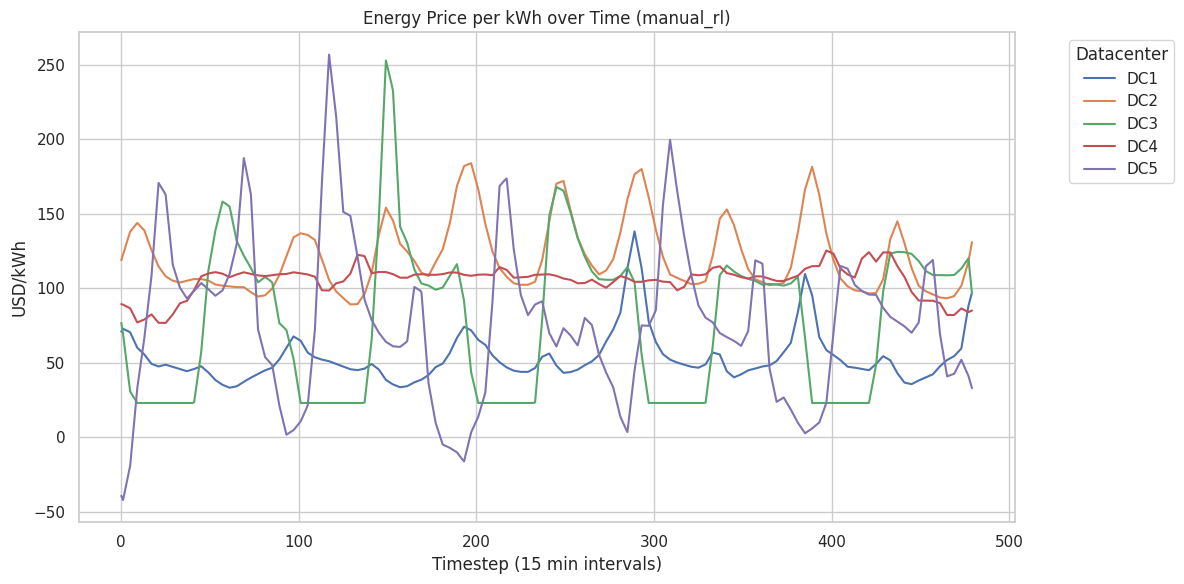

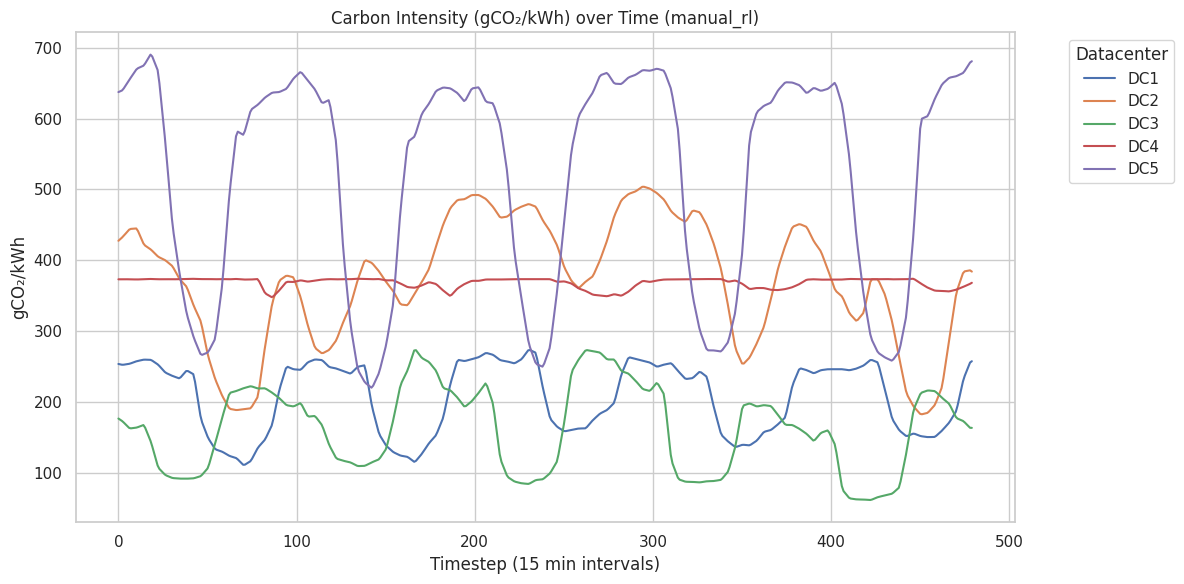

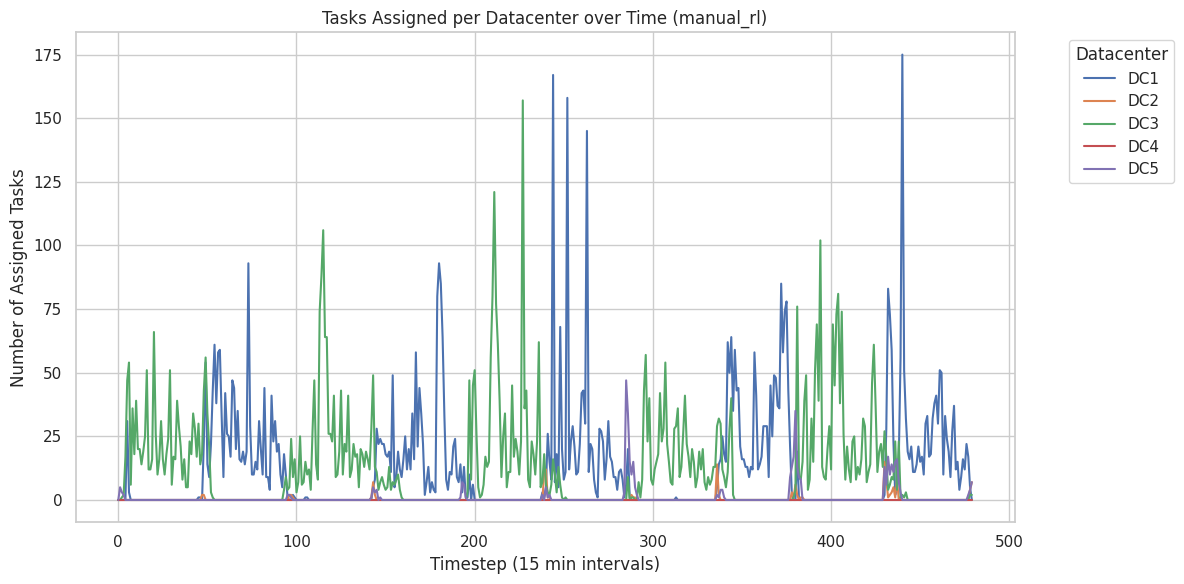

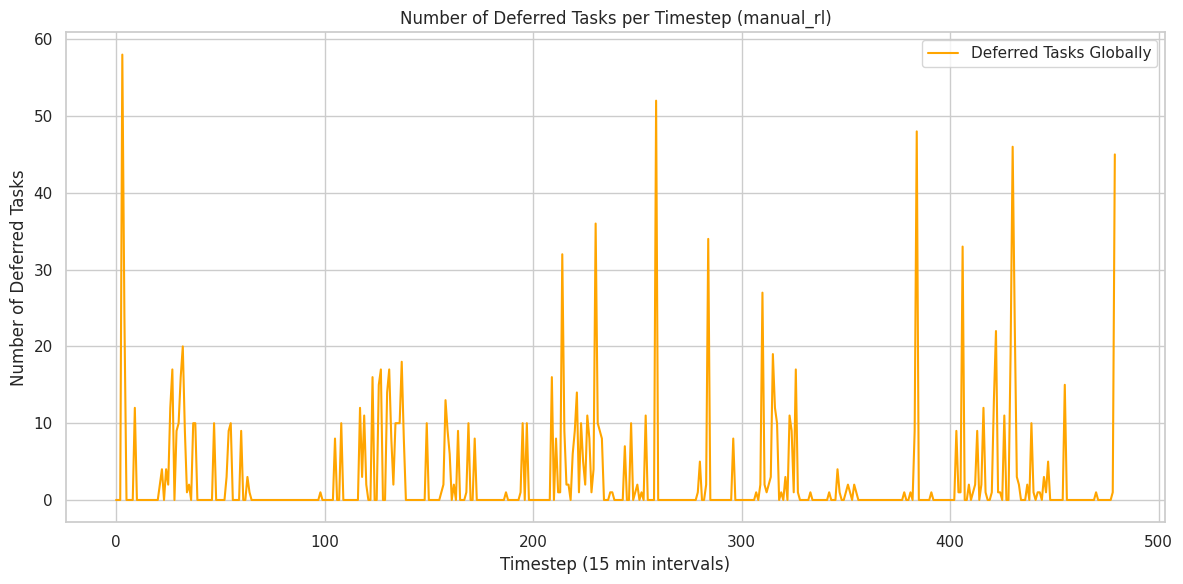

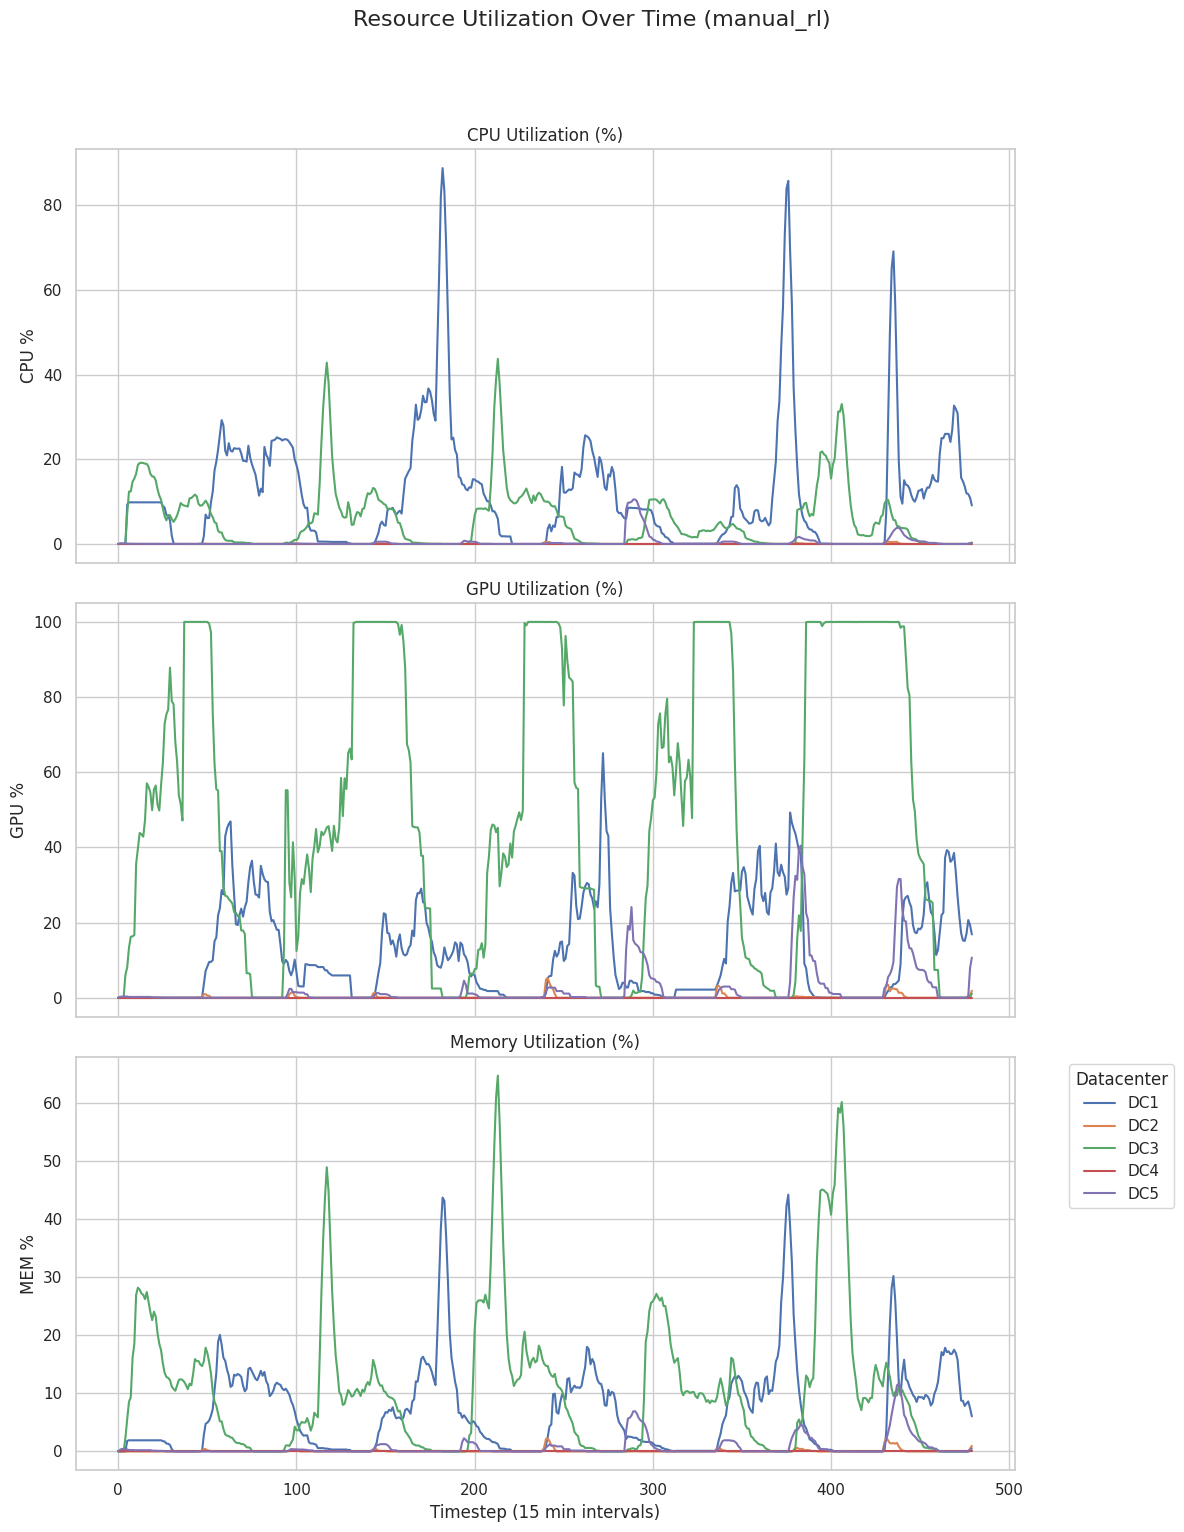

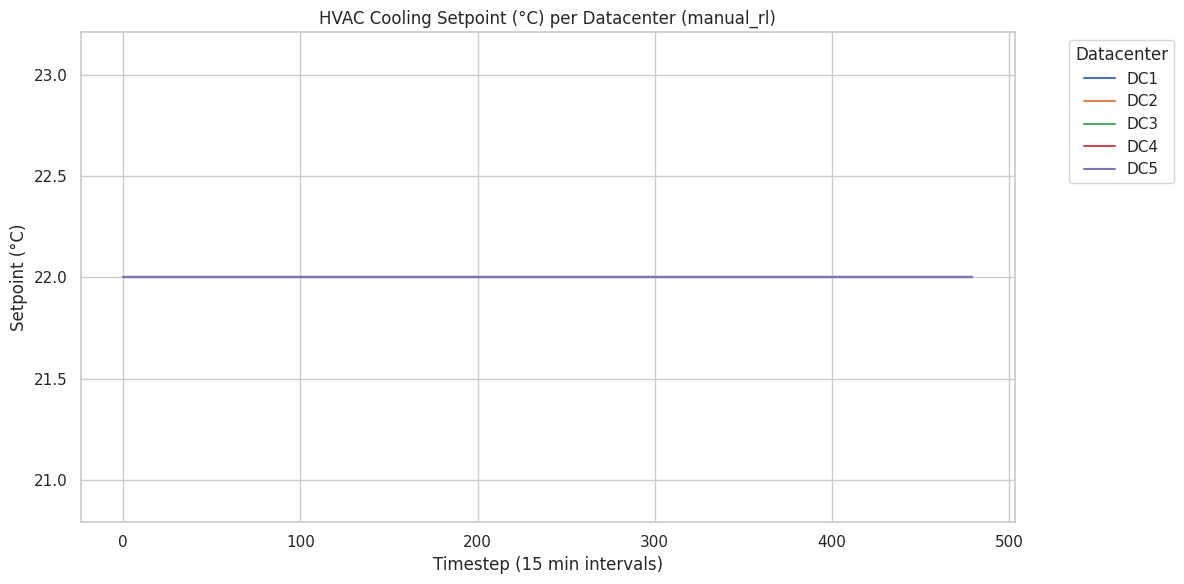

In [16]:
# Ensure dataframe is not empty before plotting
if not results_df.empty:
    plot_subset_df = results_df[results_df['timestep'] < (24 * 4 * 5)] # Plot first 2 days for clarity

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_subset_df, x="timestep", y="price_per_kwh", hue="datacenter")
    plt.title(f"Energy Price per kWh over Time ({EVALUATION_STRATEGY})")
    plt.xlabel("Timestep (15 min intervals)")
    plt.ylabel("USD/kWh")
    plt.legend(title='Datacenter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"outputs/eval_{EVALUATION_STRATEGY}_{timestamp}_price.pdf")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_subset_df, x="timestep", y="carbon_intensity_gco2_kwh", hue="datacenter")
    plt.title(f"Carbon Intensity (gCO₂/kWh) over Time ({EVALUATION_STRATEGY})")
    plt.xlabel("Timestep (15 min intervals)")
    plt.ylabel("gCO₂/kWh")
    plt.legend(title='Datacenter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"outputs/eval_{EVALUATION_STRATEGY}_{timestamp}_ci.pdf")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_subset_df, x="timestep", y="tasks_assigned_count", hue="datacenter")
    plt.title(f"Tasks Assigned per Datacenter over Time ({EVALUATION_STRATEGY})")
    plt.xlabel("Timestep (15 min intervals)")
    plt.ylabel("Number of Assigned Tasks")
    plt.legend(title='Datacenter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"outputs/eval_{EVALUATION_STRATEGY}_{timestamp}_tasks_assigned.pdf")
    plt.show()
    
    # Plot for deferred tasks (global)
    if delayed_tasks_per_step: # Check if list is not empty
        plt.figure(figsize=(12, 6))
        # Take subset for plotting if too long
        plot_delayed_subset = delayed_tasks_per_step[:len(plot_subset_df['timestep'].unique())]
        plt.plot(np.arange(len(plot_delayed_subset)), plot_delayed_subset, label="Deferred Tasks Globally", color="orange")
        plt.title(f"Number of Deferred Tasks per Timestep ({EVALUATION_STRATEGY})")
        plt.xlabel("Timestep (15 min intervals)")
        plt.ylabel("Number of Deferred Tasks")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"outputs/eval_{EVALUATION_STRATEGY}_{timestamp}_deferred_tasks.pdf")
        plt.show()

    # Utilization plots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    fig.suptitle(f'Resource Utilization Over Time ({EVALUATION_STRATEGY})', fontsize=16, y=1.02)
    
    sns.lineplot(data=plot_subset_df, x="timestep", y="cpu_util_pct", hue="datacenter", ax=axes[0], legend=False)
    axes[0].set_title("CPU Utilization (%)")
    axes[0].set_ylabel("CPU %")

    sns.lineplot(data=plot_subset_df, x="timestep", y="gpu_util_pct", hue="datacenter", ax=axes[1], legend=False)
    axes[1].set_title("GPU Utilization (%)")
    axes[1].set_ylabel("GPU %")

    sns.lineplot(data=plot_subset_df, x="timestep", y="mem_util_pct", hue="datacenter", ax=axes[2]) # Legend on last plot
    axes[2].set_title("Memory Utilization (%)")
    axes[2].set_ylabel("MEM %")
    axes[2].set_xlabel("Timestep (15 min intervals)")
    axes[2].legend(title='Datacenter', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
    plt.savefig(f"outputs/eval_{EVALUATION_STRATEGY}_{timestamp}_utilization.pdf")
    plt.show()

    # HVAC Setpoint Plot (if data exists)
    if 'hvac_setpoint_c' in plot_subset_df.columns and not plot_subset_df['hvac_setpoint_c'].isnull().all():
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=plot_subset_df, x="timestep", y="hvac_setpoint_c", hue="datacenter")
        plt.title(f"HVAC Cooling Setpoint (°C) per Datacenter ({EVALUATION_STRATEGY})")
        plt.xlabel("Timestep (15 min intervals)")
        plt.ylabel("Setpoint (°C)")
        plt.legend(title='Datacenter', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"outputs/eval_{EVALUATION_STRATEGY}_{timestamp}_hvac_setpoint.pdf")
        plt.show()
    else:
        logger.info("Skipping HVAC setpoint plot as data is missing or all NaN.")
        
else:
    logger.warning("Results DataFrame is empty, skipping plotting.")

## 9. End of Evaluation

Check the `logs/` directory for the detailed log file and the `outputs/` directory (if created by savefig commands) for saved plots.
The summary table is printed abov

In [ ]:
logger.info(f"Evaluation for {EVALUATION_STRATEGY} completed.")
# Remove handlers to prevent duplicate logging if re-running cells multiple times in one session
for handler in logger.handlers[:]:
    logger.removeHandler(handler)
    handler.close()